# Playing with rank computation

In [12]:
from scipy.sparse import save_npz, load_npz, rand, coo_matrix
import numpy as np
import tensorflow as tf
from parallelrank import find_rank

assert len(tf.config.list_physical_devices('GPU')) > 0

### Simple comparison

In [ ]:
matrix = rand(1000, 1000, density=0.0001, format='csr', dtype=np.int8)

In [3]:
%%time
rank = tf.linalg.matrix_rank(matrix.todense(), tol=1e-5).numpy()
print(rank)

92
Wall time: 723 ms


In [4]:
%%time
rank = find_rank(matrix.indptr, matrix.indices, matrix.shape[1], matrix.shape[0])
print(rank)

92
Wall time: 1.32 s


### Generate dataset to compare algorithms

In [2]:
def create_density(side, density_side):
    return (density_side / side)

In [19]:
sides = [100, 500, 1000, 5000, 10_000, 50_000]
density_side = 10
repititions = 10

In [20]:
def pseudo_random_sparce(m, n, density=0.01, format='coo'):
    tp = np.intc
    k = int(round(density * m * n))

    ind = np.random.choice(m * n, size=k, replace=True)

    j = np.floor(ind * 1. / m).astype(tp, copy=False)
    i = (ind - j * m).astype(tp, copy=False)

    return coo_matrix((np.ones(k), (i, j)), shape=(m, n)).asformat(format,
                                                             copy=False)

In [21]:
for side in sides:
    for i in range(repititions):
        density = create_density(side, density_side)
        if side > 10_000:
            matrix = pseudo_random_sparce(side, side, density, 'csr')
        else:
            matrix = rand(side, side, density=density, format='csr', dtype=np.int8)
        matrix.data[:] = 1
        save_npz("data/side_{}/matrix_{}.npz".format(side, i), matrix)

### Execure different algorithms on the generated dataset

In [7]:
from time import perf_counter

def test_algorithm(sides, repititions, algorithm_func):
    algorithm_time = []

    for side in sides:
        total_time = 0
        for i in range(repititions):
            matrix = load_npz("data/side_{}/matrix_{}.npz".format(side, i))
            time_start = perf_counter()
            algorithm_func(matrix)
            time_stop = perf_counter()
            total_time += time_stop-time_start
        algorithm_time.append(total_time / repititions)

    return np.array(algorithm_time)

In [9]:
algorithm_time = test_algorithm(
    sides, 
    repititions, 
    lambda matrix: find_rank(matrix.indptr, matrix.indices, matrix.shape[1], matrix.shape[0])
)
np.save("data/algorithm_time_v0.2.npy", algorithm_time)

In [7]:
tf_time = test_algorithm(
    sides, 
    repititions, 
    lambda matrix: tf.linalg.matrix_rank(matrix.todense(), tol=1e-5).numpy()
)
np.save("data/tf_time.npy", tf_time)

### Compare computation time

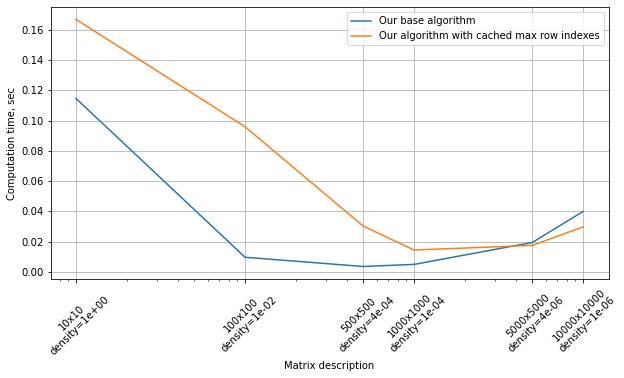

In [9]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(10, 5))
plt.plot(sides, np.load("data/tf_time.npy"), label="Tensorflow SVD on GPU")
#plt.plot(sides, np.load("data/algorithm_time_v0.1.npy"), label="Our base algorithm")
plt.plot(sides, np.load("data/algorithm_time_v0.2.npy"), label="Our algorithm with cached max row indexes")
plt.xscale('log')
plt.xticks(
    sides, 
    list(map(lambda x: "{}x{}\ndensity={:.0e}".format(
        str(x), 
        str(x), 
        create_density(x, density_side)
    ), sides)), 
    rotation=45
)
plt.legend()
plt.xlabel("Matrix description")
plt.ylabel("Computation time, sec")
plt.grid()
plt.show()